In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [2]:
boston = datasets.load_boston()

In [3]:
boston_df = pd.DataFrame(boston.data, columns=boston['feature_names'])
boston_df = boston_df.assign(PRICE=boston.target)

# ScikitLearn


### Ejercicio 1

Haga la regresion lineal de `PRICE` utilizando solamente la variable `RM`. Repita la grafica de `model vs. observation`

In [4]:
regresion = linear_model.LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(boston_df['RM'], boston_df['PRICE'], test_size=0.25)

In [5]:
regresion.fit(X_train.values.reshape(-1,1), Y_train.values.reshape(-1,1))
regresion.intercept_, regresion.coef_

(array([-36.76563353]), array([[ 9.39208249]]))

In [6]:
beta_0 = regresion.intercept_[0]
beta_1 = regresion.coef_[0,0]
Y_predict = beta_0 + beta_1 * X_test

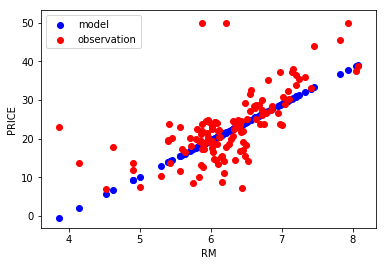

In [7]:
Y_predict = beta_0 + beta_1 * X_test
plt.scatter(X_test, Y_predict, c='blue', label='model')
plt.scatter(X_test, Y_test, c='red', label='observation')
plt.xlabel('RM')
plt.ylabel('PRICE')
plt.legend()

### Ejercicio 2
Calcule ev para la regresion lineal hecha con la variable RM.

In [8]:
explained_variance_score(Y_test, Y_predict)

0.43171188873645239

### Ejercicio 3

Haga una regresion lineal de PRICE como funcion lineal variables ZN y CRIM.

* Grafique PRICE vs CRIM y PRICE vs ZN
* Calcule ev para este modelo.


In [9]:
def apply_regression(X, Y):
    regresion = linear_model.LinearRegression()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
    
    if X_train.ndim == 1:
        X_train = X_train.values.reshape(-1,1)
        X_test = X_test.values.reshape(-1,1)
        
    regresion.fit(X_train, Y_train.values.reshape(-1,1)) 
    Y_predict = regresion.predict(X_test)
    return X_test, Y_test, Y_predict

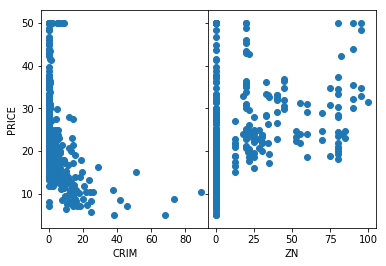

In [10]:
X_test, Y_test, Y_predict = apply_regression(boston_df[['ZN', 'CRIM']], boston_df['PRICE'])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(boston_df['CRIM'], boston_df['PRICE'])
ax2.scatter(boston_df['ZN'], boston_df['PRICE'])

ax1.set_ylabel("PRICE")
ax1.set_xlabel("CRIM")
ax2.set_xlabel("ZN")

fig.subplots_adjust(wspace = 0)

In [11]:
explained_variance_score(Y_test, Y_predict)

0.21153214655013852

### Ejercicio 4

Para decidir si el modelo de `PRICE` en funcion de `[ZN,CRIM]` es mejor que el modelo en funcion de `[LSTAT, NOX]` vamos a hacer un tornedo entre los dos modelos. Los torneos tienen 100 rondas de comparacion.

Para una ronda, haga la regresion con `[ZN,CRIM]` y calcule `ev_1` para este modelo. Luego haga la regresion con `[LSTAT, NOX]` y calcule `ev_2` para este modelo. Si `ev_1` es mayor que `ev_2` el primer modelo gano esta primera ronda comparacion.

Repita esta misma comparacion 100 veces (cada vez creando nuevos conjuntos de `test/training`) y cuente cuantas comparaciones gano cada uno de los modelos.

Vamos a decir que el modelo que gano mayor cantidad de comparaciones es el mejor en predecir `PRICE`.

In [12]:
def torneo_ronda(data_set, models, target = 'PRICE'):     
    results = {}
    
    for model in models:
        X_test, Y_test, Y_predict = apply_regression(data_set[model], data_set[target])
        results[" ".join(model)] = explained_variance_score(Y_test, Y_predict)
            
    return results

In [13]:
modelos = [['ZN', 'CRIM'], ['LSTAT', 'NOX']]
ev1 = 0
ev2 = 0
for i in range(100):
    results = torneo_ronda(boston_df, modelos)
    if results['ZN CRIM'] > results['LSTAT NOX']:
        ev1 += 1
    else:
        ev2 += 1      
print(ev1, ev2)

0 100


### Ejercicio 5

Con el mismo procedimiento anterior vamos a hacer un torneo de 100 rondas de comparacion para elegir el mejor de los modelos entre `[LSTAT, NOX]`, `[NOX, INDUS]` y `[AGE, RM]`. Esta vez en cada ronda gana el modelo con el maximo `ev`.

Escriba los 3 modelos en orden decreciente del numero de rondas ganadas.

Asi mismo para cada modelo, ademas del numero de competencias ganadas, escriba el promedio y desviacion estandar de `ev` calculado sobre los 100 valores todas las rondas.


In [14]:
def torneo(data_set, models, target = 'PRICE', rounds = 100):
    hist = {}
    values = {}
    std = {}
    for model in models:
        hist[" ".join(model)] = 0
        values[" ".join(model)] = [0]
        std[" ".join(model)] = [0]
        
    for i in range(rounds):
        results = torneo_ronda(data_set, models, target)
        result = sorted(results, key = results.get, reverse=True)[0]
        value = results[result]
        if result in hist:
            hist[result] += 1
            values[result].append(value)

    for key in values:
        std[key] = np.std(values[key])
        values[key] = np.mean(values[key])
        
    return hist, values, std

In [15]:
modelos = [['LSTAT', 'NOX'], ['NOX', 'INDUS'], ['AGE', 'RM']]
win, mean, std = torneo(boston_df, modelos)

ordenados = sorted(win, key = win.get, reverse=True)
for (i, key) in enumerate(ordenados):
    print("%d. %s: ganó %d veces. Promedio = %.3f, std = %.3f"%(i, key, win[key], mean[key], std[key]))

0. AGE RM: ganó 54 veces. Promedio = 0.585, std = 0.090
1. LSTAT NOX: ganó 46 veces. Promedio = 0.536, std = 0.089
2. NOX INDUS: ganó 0 veces. Promedio = 0.000, std = 0.000


### Ejercicio 6

Cree una lista que contenga todas las combinaciones de pares de variables en el `dataset`. La lista no debe contener los duplicados del tipo `[LSTAT,NOX]` y `[NOX,LSTAT]`, en ese caso solamente uno de los dos pares debe estar en la lista.

Hay 13 parametros, asi que la lista debe tener $(13\times 12)/2=78$ items.

In [16]:
iterador1 = list(boston_df.columns)
iterador1.remove('PRICE')
iterador2 = list(iterador1)

permutaciones = []
for name1 in iterador1:
    if iterador2:
        iterador2.remove(name1)
    for name2 in iterador2:
        permutaciones.append([name1, name2])
        
permutaciones, len(permutaciones)

([['CRIM', 'ZN'],
  ['CRIM', 'INDUS'],
  ['CRIM', 'CHAS'],
  ['CRIM', 'NOX'],
  ['CRIM', 'RM'],
  ['CRIM', 'AGE'],
  ['CRIM', 'DIS'],
  ['CRIM', 'RAD'],
  ['CRIM', 'TAX'],
  ['CRIM', 'PTRATIO'],
  ['CRIM', 'B'],
  ['CRIM', 'LSTAT'],
  ['ZN', 'INDUS'],
  ['ZN', 'CHAS'],
  ['ZN', 'NOX'],
  ['ZN', 'RM'],
  ['ZN', 'AGE'],
  ['ZN', 'DIS'],
  ['ZN', 'RAD'],
  ['ZN', 'TAX'],
  ['ZN', 'PTRATIO'],
  ['ZN', 'B'],
  ['ZN', 'LSTAT'],
  ['INDUS', 'CHAS'],
  ['INDUS', 'NOX'],
  ['INDUS', 'RM'],
  ['INDUS', 'AGE'],
  ['INDUS', 'DIS'],
  ['INDUS', 'RAD'],
  ['INDUS', 'TAX'],
  ['INDUS', 'PTRATIO'],
  ['INDUS', 'B'],
  ['INDUS', 'LSTAT'],
  ['CHAS', 'NOX'],
  ['CHAS', 'RM'],
  ['CHAS', 'AGE'],
  ['CHAS', 'DIS'],
  ['CHAS', 'RAD'],
  ['CHAS', 'TAX'],
  ['CHAS', 'PTRATIO'],
  ['CHAS', 'B'],
  ['CHAS', 'LSTAT'],
  ['NOX', 'RM'],
  ['NOX', 'AGE'],
  ['NOX', 'DIS'],
  ['NOX', 'RAD'],
  ['NOX', 'TAX'],
  ['NOX', 'PTRATIO'],
  ['NOX', 'B'],
  ['NOX', 'LSTAT'],
  ['RM', 'AGE'],
  ['RM', 'DIS'],
  ['RM', 'RAD']

### Ejercicio 7

Ahora el torneo tiene los 78 competidores de la lista anterior. Haga 500 rondas de comparacion y calcule el numero de veces que cada modelo gana. Finalmente, escriba los modelos en orden decreciente de numero de rondas ganadas junto a su valor promedio de ev sobre las 500 rondas.

Finalmente, cual es el par de variables que mejor describe los datos?

In [17]:
win, mean, std = torneo(boston_df, permutaciones, rounds=500)

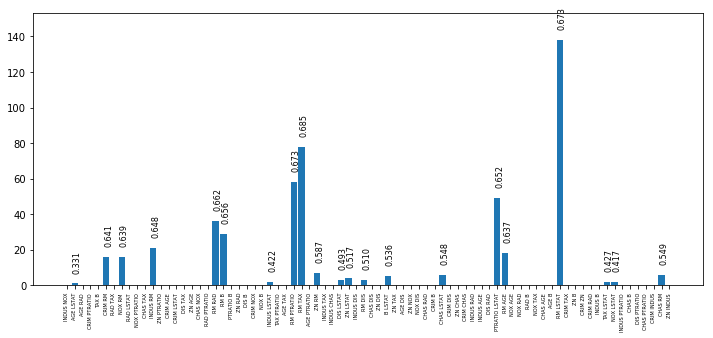

In [18]:
N = len(win)
hist_values = list(win.values())
keys = list(win.keys())

fig = plt.figure(figsize=(12, 5))
plt.bar(range(N), hist_values)
plt.xticks(range(N), keys, rotation='vertical', fontsize=5)

for i in range(N):
    if mean[keys[i]] > 0:
        plt.text(i-0.25, hist_values[i] + 15, "%.3f"%mean[keys[i]], rotation = 'vertical', fontsize=8)

plt.ylim(0, max(hist_values) + 15)
plt.show()